Automatic differentiation or `autodiff` is useful for implementing algorithms like backpropagation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2023-03-27 09:35:31.934266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 09:35:32.021664: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-27 09:35:32.043701: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-27 09:35:32.444124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

`tf.GradientTape` API does automatic differentiation for some inputs, usually tf.Variables. TensorFlow records the operations executed within GradientTape and then uses reverse mode differentiation to compute gradients of them

In [2]:
x = tf.Variable(4.0)

with tf.GradientTape() as tape:
    y = x**3

dy_dx = tape.gradient(y, x)
dy_dx.numpy()

2023-03-27 09:35:33.037988: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-03-27 09:35:33.038029: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ssk-Dell-G15-5511
2023-03-27 09:35:33.038035: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ssk-Dell-G15-5511
2023-03-27 09:35:33.038137: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.85.12
2023-03-27 09:35:33.038158: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.85.12
2023-03-27 09:35:33.038164: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.85.12
2023-03-27 09:35:33.040007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

48.0

We can make `tf.GradientTape` work easily on any tensor

In [3]:
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
    y = x @ w + b
    loss = tf.reduce_mean(y ** 2)

In [4]:
[d1_dw, d1_db] = tape.gradient(loss, [w, b])

We can also use a dictionary of the tf.Variables

In [5]:
vars = {
    'w' : w,
    'b' : b
}

grad = tape.gradient(loss, vars)
grad['b']

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-2.7205412, -3.3055012], dtype=float32)>

tf.Variables are collected in a `tf.Module` or one of the subclasses for checkpointing. We can use the `Module.trainable_variables` property to calculate the gradient.

In [6]:
layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
    y = layer(x)
    loss = tf.reduce_mean(y**2)

grad = tape.gradient(loss, layer.trainable_variables)

In [7]:
for var, grads in zip(layer.trainable_variables, grad):
    print(f'{var.name}, shape: {grads.shape}')

dense/kernel:0, shape: (3, 2)
dense/bias:0, shape: (2,)


TensorFlow watches all operations that takes place on a tf.Variable. However does not record those on a tf.Tensor, so the below operation fails.

In [8]:
x0 = tf.Variable(3.0, name='x0')
x1 = tf.Variable(3.0, name='x1', trainable=False)
# A tf.Tensor when added to a tf.Variable gives a tf.Tensor
x2 = tf.Variable(2.0, name='x2') + 1.0
x3 = tf.constant(3.0, name='x3')

with tf.GradientTape() as tape:
    y = (x0**2) + (x1**2) + (x2**2)

grads = tape.gradient(y, [x0, x1, x2, x3])

for grad in grads:
    print(grad)

[var.name for var in tape.watched_variables()]

tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None


['x0:0']

We can use `GradientTape.watch(x)` to watch over a tf.Tensor x

In [9]:
x0 = tf.Variable(3.0, name='x0')
x1 = tf.Variable(3.0, name='x1', trainable=False)
# A tf.Tensor when added to a tf.Variable gives a tf.Tensor
x2 = tf.Variable(2.0, name='x2') + 1.0
x3 = tf.constant(3.0, name='x3')

with tf.GradientTape() as tape:
    tape.watch(x2)
    y = (x0**2) + (x1**2) + (x2**2)

grads = tape.gradient(y, [x0, x1, x2, x3])

for grad in grads:
    print(grad)

[var.name for var in tape.watched_variables()]

tf.Tensor(6.0, shape=(), dtype=float32)
None
tf.Tensor(6.0, shape=(), dtype=float32)
None


['x0:0']

We can set `watch_accessed_variables=False` while creating the gradient tape. This will disable watching over all tf.Variables by default.

In [10]:
x0 = tf.Variable(1.0, name='x0')
x1 = tf.Variable(10.0, name='x1')

with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(x1)
    y0 = tf.math.sin(x0)
    y1 = tf.nn.softplus(x1)
    y = y0 + y1
    ys = tf.reduce_sum(y)

grad = tape.gradient(ys, {'x0' : x0, 'x1' : x1})
print('dy_dx0', grad['x0'])
print('dy_dx1', grad['x1'])

dy_dx0 None
dy_dx1 tf.Tensor(0.9999546, shape=(), dtype=float32)


We can also calculate gradients with respect to the intermediate values computed with in tf.GradientTape

In [11]:
x = tf.constant(3.0)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = x * x
    z = y * y

tape.gradient(z, y)

<tf.Tensor: shape=(), dtype=float32, numpy=18.0>

All resources help by GradientTape are released the instant GradientTape.gradient is called. To compute multiple gradients or to call the method again without creating GradientTape again, we must set `persistent=True` while creating the GradientTape. The resources are freed when reference to tape is dropped. However if we use this, the peak memory usage will be high as even intermediate results won't be discarded.

In [12]:
x = tf.constant([1, 3.0])

with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    y = x * x
    z = y * y

In [13]:
print(tape.gradient(z, x))
print(tape.gradient(y, x))

tf.Tensor([  4. 108.], shape=(2,), dtype=float32)
tf.Tensor([2. 6.], shape=(2,), dtype=float32)


In [14]:
del tape

Gradients of non-scalar targets, i.e. the differentiation of multiple targets with respect to single variable will be the sum of the gradients, or the gradient of the sum.

In [24]:
x = tf.Variable(2.0)

with tf.GradientTape(persistent=True) as tape:
    y0 = x**2
    y1 = 1 / x
    y2 = x * [3., 4.]

print(tape.gradient(y0, x))
print(tape.gradient(y1, x))
print(tape.gradient({'y0' : y0, 'y1' : y1}, x))
print(tape.gradient(y2, x))

tf.Tensor(4.0, shape=(), dtype=float32)
tf.Tensor(-0.25, shape=(), dtype=float32)
tf.Tensor(3.75, shape=(), dtype=float32)
tf.Tensor(7.0, shape=(), dtype=float32)


Gradients of multiple elements

Text(0, 0.5, 'Y')

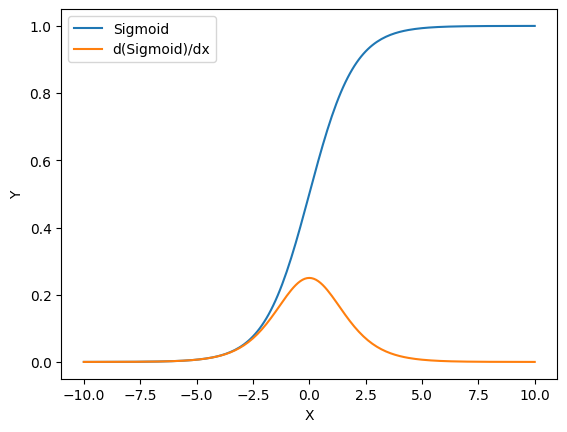

In [26]:
x = tf.linspace(-10, 10, 201)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.nn.sigmoid(x)

dy_dx = tape.gradient(y, x)

# Plotting the graph of differentiation of the sigmoid function, and the actual function
plt.plot(x, y, label='Sigmoid')
plt.plot(x, dy_dx, label='d(Sigmoid)/dx')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')

Conditionals and loops can be used inside GradientTape. They are invisible to the function so won't be differentiated. However they can affect the differentiation.

In [54]:
x = tf.constant(1.0)
v0 = tf.Variable(2.0)
v1 = tf.Variable(2.0)

with tf.GradientTape() as tape:
    tape.watch(x)
    if (x > 0.0):
        result = v0
    else:
        result = v1 ** 2

dv0, dv1, dx = tape.gradient(result, [v0, v1, x])
print(dv0)
print(dv1)
print(dx)

tf.Tensor(1.0, shape=(), dtype=float32)
None
None


Whenever `None` is returned it means that there's no connection between the variables, or one of the inputs are not tf.Variables, or calculations were made outside tensorflow.

When the tf.Variable becomes a tensor

In [64]:
x0 = tf.Variable(3.0)
x1 = tf.Variable(3.0)

for epoch in range(2):
    with tf.GradientTape(persistent=True) as tape:
        y0 = x0 + 1
        y1 = x1 + 1
    print(tape.gradient(y0, x0))
    print(tape.gradient(y1, x1))
    x0 = x0 + 1                 # Adding like this makes the tf.Variable a tensor
    x1.assign_add(1)            # Adding like this ensures the tf.Variable stays of the same type

del tape

tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
None
tf.Tensor(1.0, shape=(), dtype=float32)


When calculations take place outside TensorFlow

In [78]:
x =  tf.Variable([[1., 2.],
                  [3., 4.]], dtype=tf.float32)

with tf.GradientTape(persistent=True) as tape:
    x2 = x**2
    y0 = np.mean(x2, axis=0)        # We used numpy so tf does not have track of what happened
    y0 = tf.reduce_mean(y0)
    y1 = tf.reduce_mean(x2)

print(tape.gradient(y0, x))
print(tape.gradient(y1, x))

del tape

None
tf.Tensor(
[[0.5 1. ]
 [1.5 2. ]], shape=(2, 2), dtype=float32)


If we use an integer or string instead of a float

In [82]:
x0 = tf.constant(10)
x1 = tf.constant(10.)

with tf.GradientTape(persistent=True) as tape:
  tape.watch(x0)
  tape.watch(x1)
  y0 = x0 * x0      # Since x0 is an integer
  y1 = x1 * x1      # x1 is a float so it works

print(tape.gradient(y0, x0))
print(tape.gradient(y1, x1))

del tape


None
tf.Tensor(20.0, shape=(), dtype=float32)


We can set if we want `None` to be returned or `zeros` when the gradient does not exist. We use `unconnected_gradients=tf.UnconnectedGradients.ZERO` arguments while calling GradientTape.gradient

In [84]:
x = tf.Variable([1., 2.])
y = tf.Variable(3.)

with tf.GradientTape(persistent=True) as tape:
    z = y * y

print(tape.gradient(z, x))
print(tape.gradient(z, y, unconnected_gradients=tf.UnconnectedGradients.ZERO))

del tape

None
tf.Tensor(6.0, shape=(), dtype=float32)
